In [2]:
import torch

import numpy as np
from scipy.integrate import solve_ivp

from sbi import utils as sbi_utils
from sbi.inference import NPE, simulate_for_sbi
from sbi.analysis import pairplot
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)


In [43]:
def multiphase_tank(theta):
    """
    Simplified tank model for multiphase flow.

    theta: [k_P, k_alpha, Q_g, Q_l]
    """
    k_P, k_alpha, Q_g, Q_l = theta
    
    Q_out = 0.05  # fixed known outflow
    P0 = 5e6      # initial pressure (Pa)
    alpha0 = 0.2  # initial gas fraction

    def rhs(t, y):
        P, alpha = y
        
        dP_dt = k_P * (Q_g - alpha * Q_out)
        d_alpha_dt = k_alpha * ((Q_g / (Q_g + Q_l)) - alpha)
        
        return [dP_dt, d_alpha_dt]

    t_span = (0, 200)
    t_eval = np.linspace(*t_span, 200)
    sol = solve_ivp(rhs, t_span, [P0, alpha0], t_eval=t_eval)

    if not sol.success:
        raise RuntimeError("Simulation failed")

    return sol.y.flatten()

In [22]:
def multiphase_tank_summary(theta):
    output = multiphase_tank(theta).flatten()
    P, alpha = output[:200], output[200:]

    def slope(y):
        return (y[-1] - y[0]) / 200
    
    def time_to_equilibrium(y, tol=1e-2):
        for i in range(1, len(y)):
            if np.abs(y[i] - y[-1]) < tol:
                return i
        return len(y)

    stats = np.array([
        np.mean(P), np.std(P), P[-1], slope(P), time_to_equilibrium(P),
        np.mean(alpha), np.std(alpha), alpha[-1], slope(alpha), time_to_equilibrium(alpha),
    ])

    return stats


def multiphase_tank_summary_snapshots(theta):
    output = multiphase_tank(theta).flatten()
    P, alpha = output[:200], output[200:]

    # Choose snapshot time points
    t0, t1, t2, t3, t4, t5 = 1, 20, 50, 100, 150, 199  # early, mid, late

    stats = np.array([
        P[t0], P[t1], P[t2], P[t3], P[t4], P[t5],
        alpha[t0], alpha[t1], alpha[t2],  alpha[t3], alpha[t4], alpha[t5]
    ])

    return stats

In [23]:
prior = sbi_utils.BoxUniform(
    low=torch.tensor([2e4, 0.05, 0.003, 0.025]),
    high=torch.tensor([8e4, 0.2, 0.007, 0.035])
)
# prior1 = sbi_utils.BoxUniform(
#     low=torch.tensor([1e3, 0.01, 0.001, 0.01]),
#     high=torch.tensor([1e5, 1.0, 0.01, 0.05])
# )

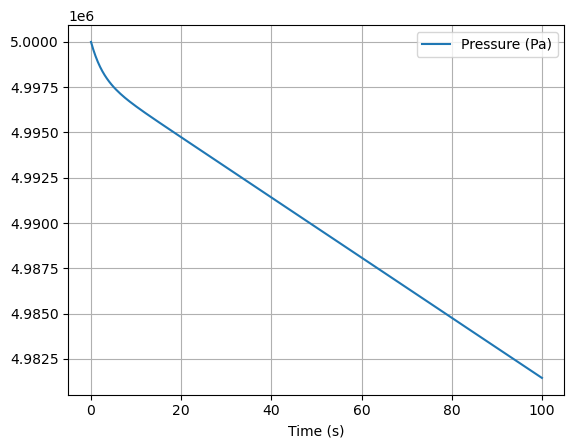

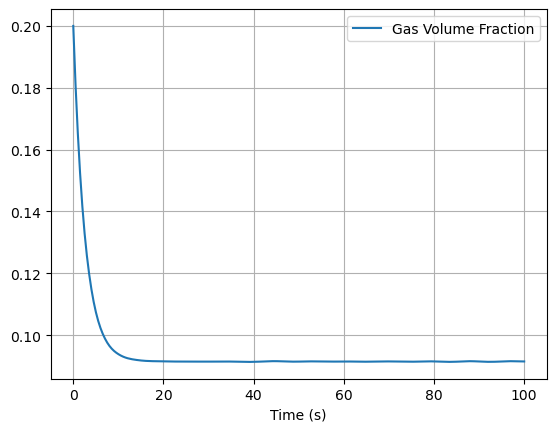

In [24]:
theta_example = prior.sample()
output = multiphase_tank(theta_example).flatten()
P, alpha = output[:200], output[200:]

import matplotlib.pyplot as plt
t = np.linspace(0, 100, 200)

plt.plot(t, P, label="Pressure (Pa)")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(t, alpha, label="Gas Volume Fraction")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
prior, num_parameters, prior_returns_numpy = process_prior(prior)

simulator_wrapper = process_simulator(
    multiphase_tank_summary,
    prior,
    prior_returns_numpy
)

check_sbi_inputs(simulator_wrapper, prior)


In [26]:
num_simulations = 10000  # Number of simulations

# Using simulator_wrapper and prior defined above
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations)
inference = NPE(prior=prior)
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

  0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 254 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

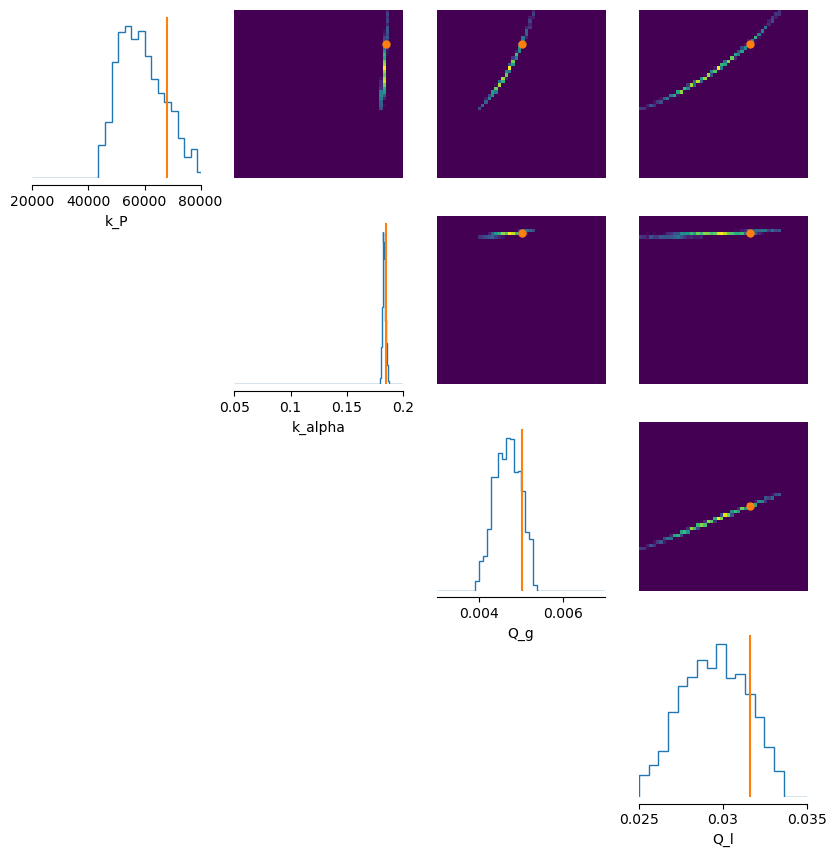

In [33]:
# Synthetic observation
# true_theta = torch.tensor([[5e4, 0.1, 0.005, 0.03]])
true_theta = np.array([prior.sample()])
x_o = simulator_wrapper(true_theta)

# Sample posterior
posterior_samples = posterior.sample((1000,), x=x_o)

param_labels = ['k_P', 'k_alpha', 'Q_g', 'Q_l']
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]

fig, ax = pairplot(
    posterior_samples,
    points=true_theta,
    labels=param_labels,
    limits=limits
)

In [ ]:
import torch.nn as nn
from sbi.neural_nets import posterior_nn
from sbi.inference import NPE

embedding_net = nn.Sequential(
    nn.Linear(400, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 10)  # Final embedded representation
)

# Define density estimator using the embedding net
density_estimator = posterior_nn(model='maf', embedding_net=embedding_net)
inference = NPE(prior=prior, density_estimator=density_estimator)

In [53]:
simulator_wrapper = process_simulator(
    multiphase_tank,
    prior,
    prior_returns_numpy
)

theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=1000)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

  0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 55 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

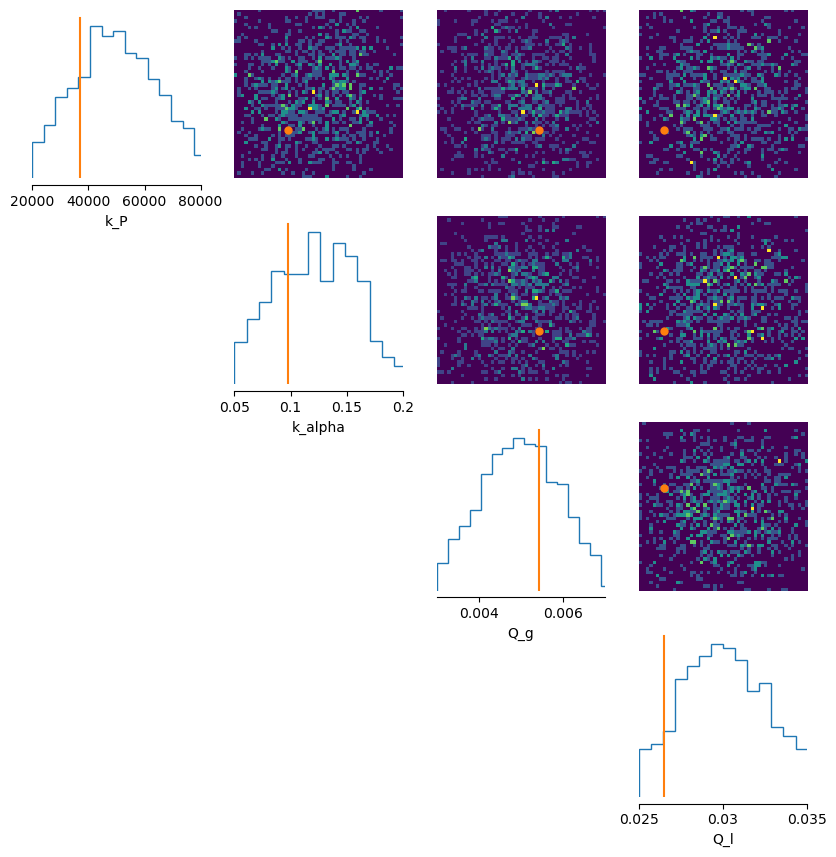

In [57]:
# Synthetic observation
# true_theta = torch.tensor([[5e4, 0.1, 0.005, 0.03]])
true_theta = np.array([prior.sample()])
x_o = simulator_wrapper(true_theta)

# Sample posterior
posterior_samples = posterior.sample((1000,), x=x_o)

param_labels = ['k_P', 'k_alpha', 'Q_g', 'Q_l']
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]

fig, ax = pairplot(
    posterior_samples,
    points=true_theta,
    labels=param_labels,
    limits=limits
)

In [58]:
embedding_net = nn.Sequential(
    nn.Conv1d(in_channels=2, out_channels=16, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.AdaptiveAvgPool1d(10),
    nn.Flatten(),
    nn.Linear(32 * 10, 10)  # Final embedding
)

# Define density estimator using the embedding net
density_estimator = posterior_nn(model='maf', embedding_net=embedding_net)
inference = NPE(prior=prior, density_estimator=density_estimator)

In [59]:
def multiphase_tank_for_cnn(theta):
    output = multiphase_tank(theta)  # shape: (400,)
    output = output.reshape(2, 200)  # [channels, time]
    return output.astype(np.float32)

simulator_wrapper = process_simulator(
    multiphase_tank_for_cnn,
    prior,
    prior_returns_numpy
)

theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=1000)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

  0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 44 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

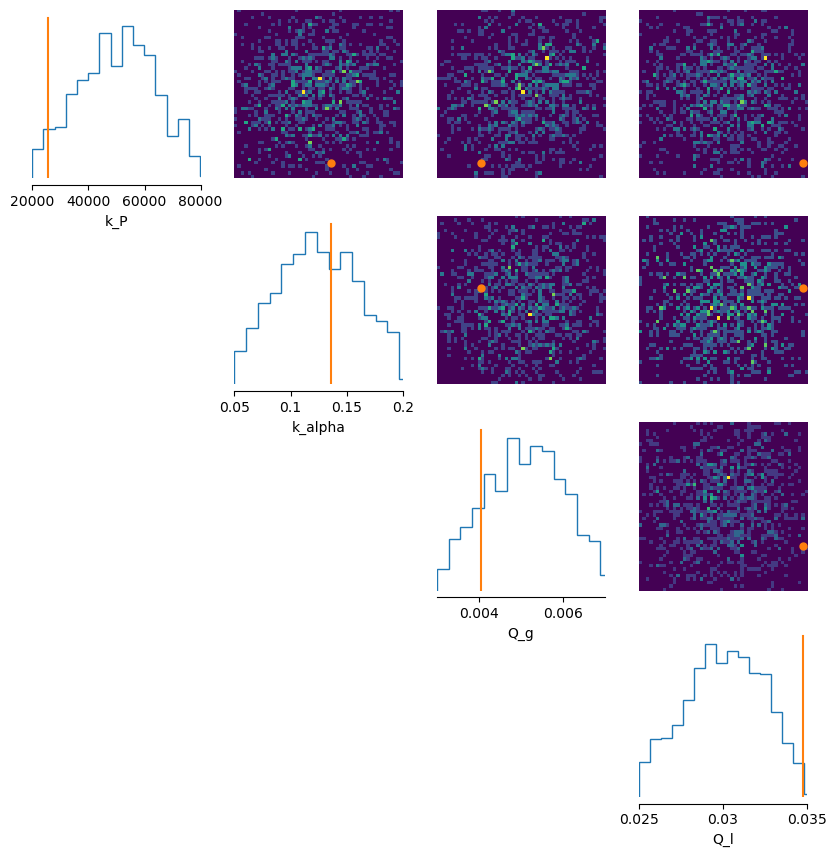

In [60]:
# Synthetic observation
# true_theta = torch.tensor([[5e4, 0.1, 0.005, 0.03]])
true_theta = np.array([prior.sample()])
x_o = simulator_wrapper(true_theta)

# Sample posterior
posterior_samples = posterior.sample((1000,), x=x_o)

param_labels = ['k_P', 'k_alpha', 'Q_g', 'Q_l']
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]

fig, ax = pairplot(
    posterior_samples,
    points=true_theta,
    labels=param_labels,
    limits=limits
)